# Apartat (C): Analitzant Dades

In [8]:
import sklearn
import numpy as np
import matplotlib
import scipy
import pandas as pd
import scipy.stats
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from scipy.stats import normaltest
import seaborn as sns
%matplotlib notebook


# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset
# Carreguem dataset d'exemple
dataset = load_dataset('COMBO17.csv')
data = dataset.values

x = data[:, :2]
y = data[:, 2]

# Per veure les dimensionalitats
print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X:", x.shape)
print("Dimensionalitat de l'atribut Y:", y.shape)

Dimensionalitat de la BBDD: (3462, 65)
Dimensionalitat de les entrades X: (3462, 2)
Dimensionalitat de l'atribut Y: (3462,)


In [9]:
# Per veure totes les columnes amb valors inexistents
x = dataset.isnull().sum()
null_columns = dataset.columns[dataset.isnull().any()]
print(null_columns)
print(dataset[null_columns].isnull().sum())
print("Total de valors no existents:",dataset.isnull().sum().sum())
# Tipus de cada atribut: 
print(dataset.dtypes)

Index(['VnMAG', 'e.VbMAG', 'S280MAG', 'e.S280MA'], dtype='object')
VnMAG        1
e.VbMAG      1
S280MAG     24
e.S280MA    24
dtype: int64
Total de valors no existents: 50
Nr           int64
Rmag       float64
e.Rmag     float64
ApDRmag    float64
mumax      float64
            ...   
e.VFD      float64
RFS        float64
e.RFS      float64
IFD        float64
e.IFD      float64
Length: 65, dtype: object


In [10]:
# Creamos una lista para seleccionar los nombres de columnas que queremos dropear
dataTypeDict = dict(dataset.dtypes)
lst = []
for x in dataTypeDict:
    lst.append(x)
    
# Drop de la columna 1 que contiene el indice 
dataset = dataset.drop(columns='Nr')

# Quitamos las columnas entre la 56 y la 65 al ser valores redundantes de las 13 anteriores
lst2 = lst[-10:]
# Eliminem valors inexistents
dataset = dataset.dropna()

# Drop de las columnas que den info acerca de los errores
for x in lst:
    if "e." in x:
        lst2.append(x)
dataset = dataset.drop(columns = lst2)
print("Total de valors no existents:", dataset.isnull().sum().sum())
    

Total de valors no existents: 0


In [11]:
# Apliquem el test de Shapiro per veure si es segueix una distribució Gaussiana
columns = dataset.columns
for column in columns:
    normal, value = (shapiro(dataset[column]))
    rounded_value = round(value, 5)
    if rounded_value > 0.05:
        print('Probably Gaussian')
    else:
        print("Probably not Gaussian")
# No tenim cap columna del dataset que seguieixi una distribució Gaussiana

Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian
Probably not Gaussian


<IPython.core.display.Javascript object>


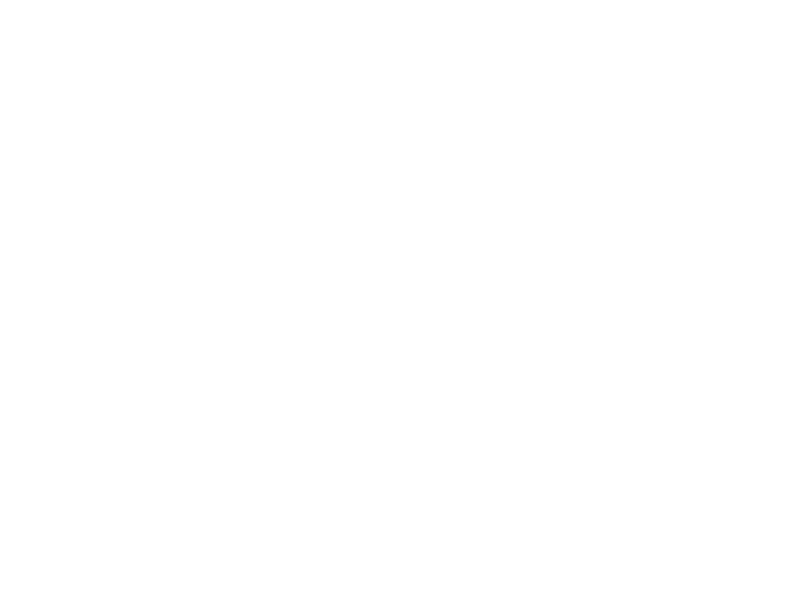

<IPython.core.display.Javascript object>


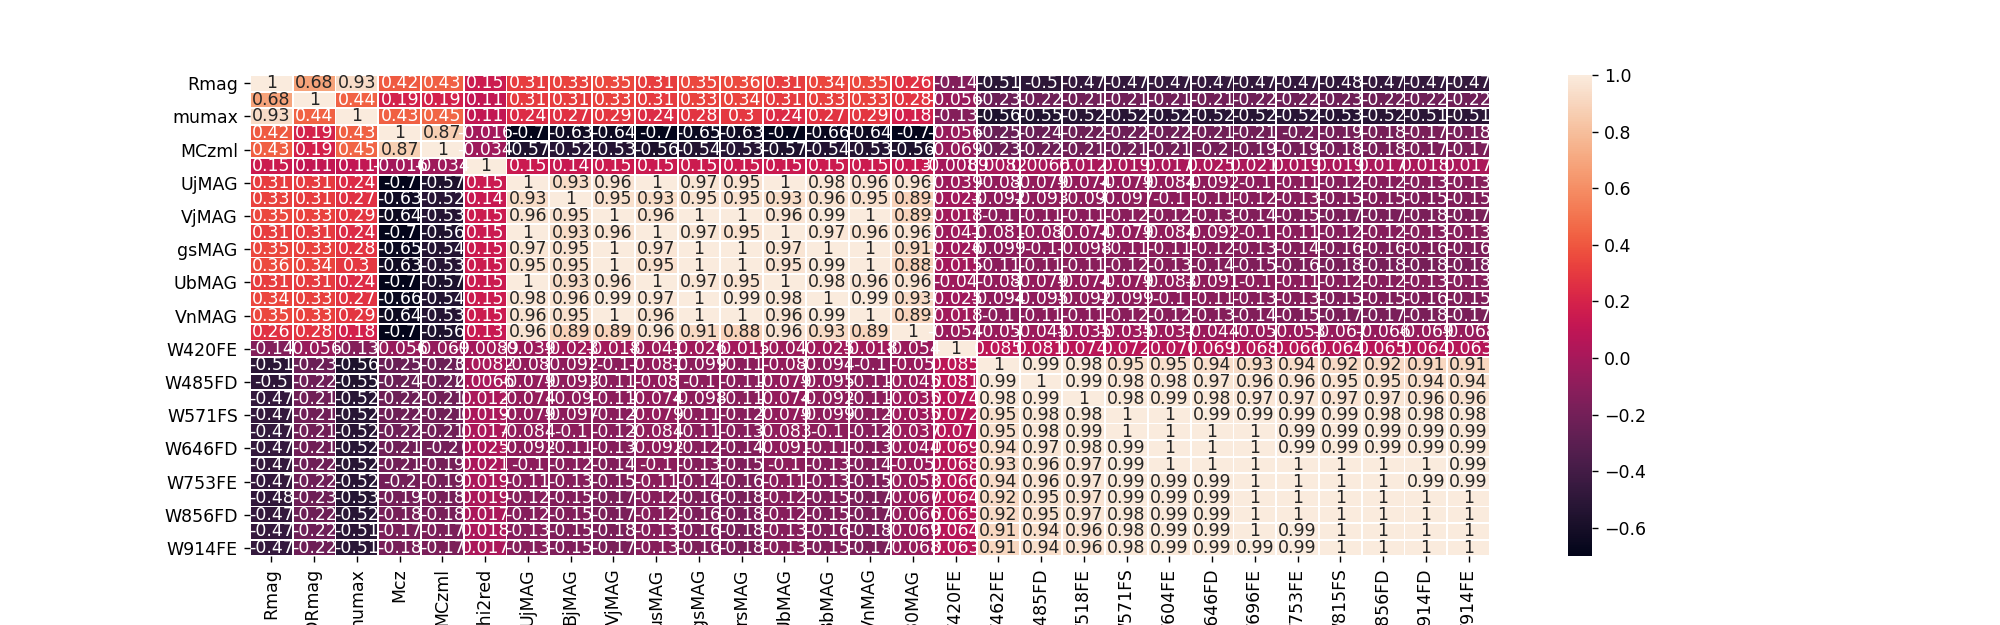

In [12]:
# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dataset.corr()

plt.figure()
plt.figure(figsize=(16, 5))
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

<IPython.core.display.Javascript object>


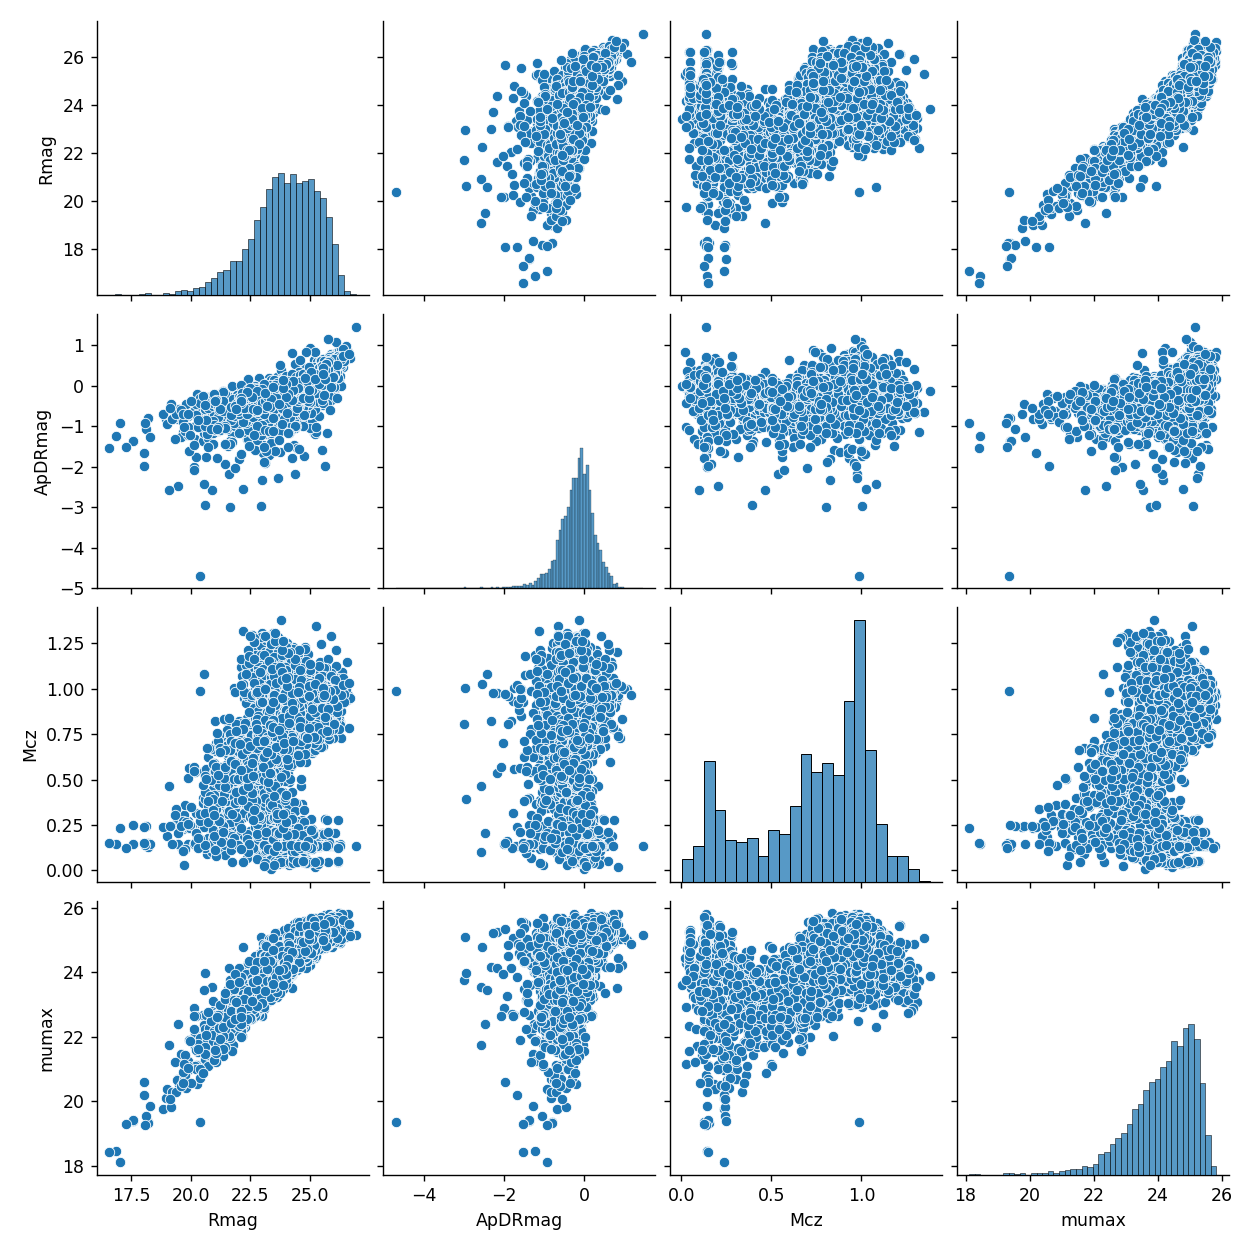

<IPython.core.display.Javascript object>


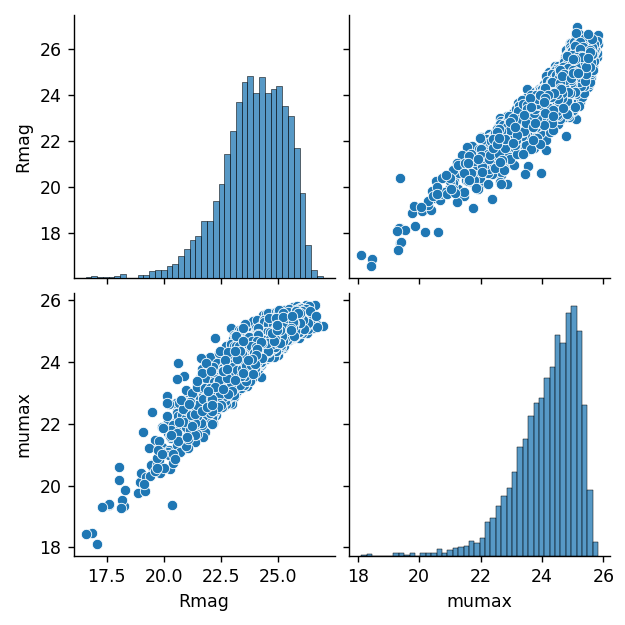

In [13]:
#en el dataset se habla de la correlación entre Rmag y mumax para sacar los tamaños de las galaxias
#si bien es cierto que nos encontramos que cierto grupo de atributos son muc correlativos 
#(el cuadrado ese que se ve, decir las columnas), hay que tener en cuenta que son datos muy parecidos/relacionados (bandas 
#cercanas en la medición), por lo que no se saca mucho de ahí

#comprobamos la correlación entre estos dos datos mediante gráficos

relacio = sns.pairplot(dataset[["Rmag", "ApDRmag", "Mcz", "mumax"]])

rel_Rmag_mumax = dataset[["Rmag","mumax"]]
relacio = sns.pairplot(rel_Rmag_mumax)


<IPython.core.display.Javascript object>


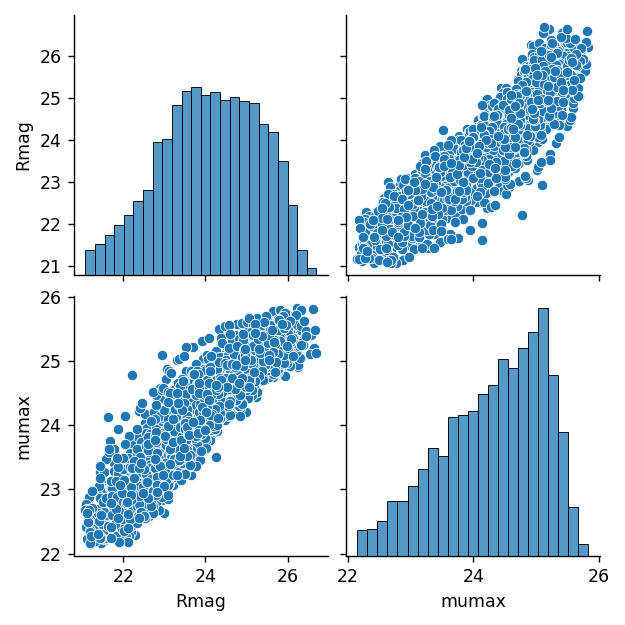

'columnsx = rel_Rmag_mumax2.columns\nfor column in columnsx:\n    normal, value = (shapiro(dataset[column]))\n    rounded_value = round(value, 10)\n    if rounded_value > 0.05:\n        print(\'Probably Gaussian\')\n    else:\n        print("Probably not Gaussian")\n    print(rounded_value)\n    print(value)'

In [14]:
#Si bien la correlación es buena, es necesario normalizar los datos para hacerlos más consistentes
#suprimimos los outliers con z_score, que nos indica lo lejos que está cada dato de la media(?) del atributo 
#(https://www.statisticshowto.com/probability-and-statistics/z-score/)

from scipy import stats
rel_Rmag_mumax2 = rel_Rmag_mumax[(np.abs(stats.zscore(rel_Rmag_mumax)) < 2).all(axis=1)]

#comprobamos la correlación entre estos dos datos mediante gráficos
relacio = sns.pairplot(rel_Rmag_mumax2)

"""columnsx = rel_Rmag_mumax2.columns
for column in columnsx:
    normal, value = (shapiro(dataset[column]))
    rounded_value = round(value, 10)
    if rounded_value > 0.05:
        print('Probably Gaussian')
    else:
        print("Probably not Gaussian")
    print(rounded_value)
    print(value)"""

#Vemos que siguen sin ser gaussianas pero al menos hemos quitado parte de los outliers
# aún podemos ajustar el dataset con Chi-square y su relación con los outliers + indicaciones del propio dataset que
#indican qué datos descartar (galaxias débiles, con mucho error en algún atributo como para ser fiables, etc)

#probemos la efectividad de hacer predicciones con este dataset



## APARTADO B: PRIMERAS REGRESIONES

In [15]:
# CÁLCULO DEL ERROR CUADRÁTICO

import math

def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

mean_squeared_error([1,2,3,4], [1,2,1,4])

1.0

In [16]:
np.warnings.filterwarnings('ignore')

vector1 = np.array([1,2,3,4]) # convertim llista de python a numpy array
vector2 = np.array([1,2,1,4]) 

# podem sumar dos vectors element a element
print("Suma vector1 + vector2 ", vector1 + vector2)

# podem sumar tots els valors d'un vector
print("Suma valors vector1 ", vector1.sum())

# calculem la mitjana
print("Mitjana vector1", vector1.mean())

# utilitzem un vector com a índex de l'altre
# vector3 = vector1  # necesitem fer una copia del vector per no modificar el original
vector3 = vector1.copy()
vector3[vector2 == 1] = 5
print("Vector1 amb un 5 on el Vector2 te 1s ", vector3)

# es pot utilitzar numpy per a calcular el mse
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

print("MSE: ", mse(vector1, vector2))

Suma vector1 + vector2  [2 4 4 8]
Suma valors vector1  10
Mitjana vector1 2.5
Vector1 amb un 5 on el Vector2 te 1s  [5 2 5 4]
MSE:  1.0


          Rmag    mumax
count 3438.000 3438.000
mean    23.927   24.175
std      1.432    1.017
min     16.572   18.112
25%     23.095   23.616
50%     24.057   24.382
75%     25.016   24.946
max     26.954   25.833


<IPython.core.display.Javascript object>


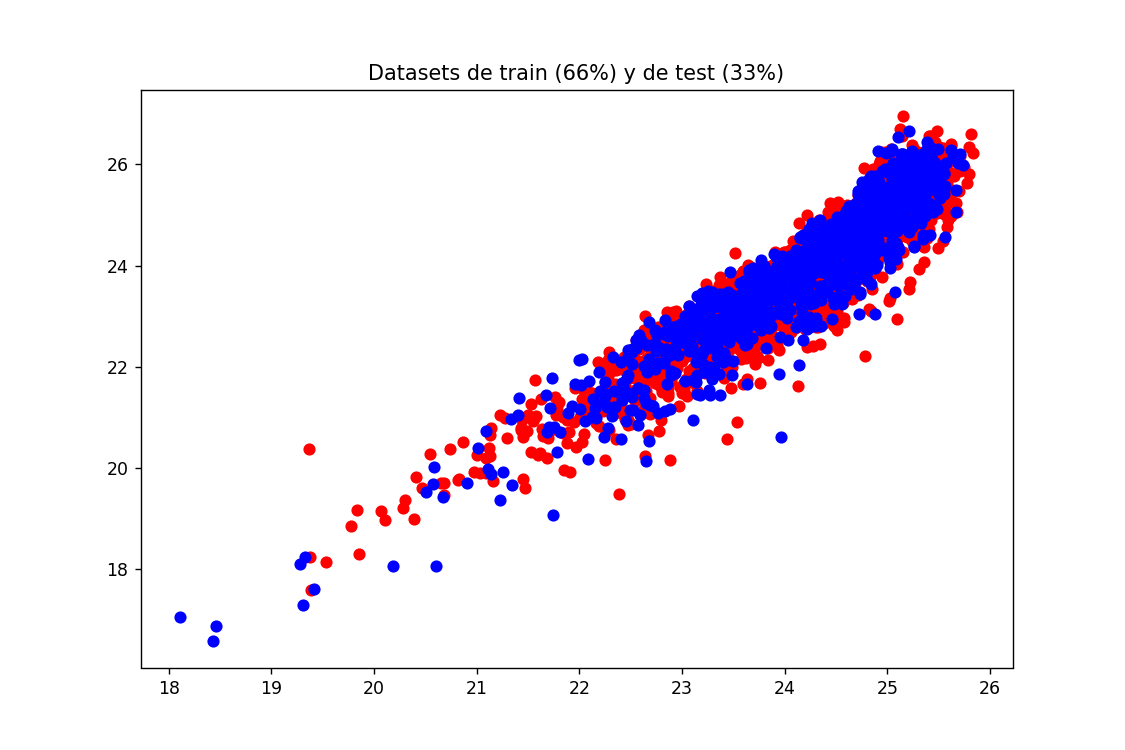

Text(0.5, 1.0, 'Datasets de train (66%) y de test (33%)')

In [17]:
#Hacemos la separación entre datos de test y datos de training

from sklearn.model_selection import train_test_split

test_size = 0.33

ds = rel_Rmag_mumax


x = ds[["Rmag"]]
y = ds[["mumax"]]

print(ds.describe())

# split into training, validation, and testing sets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

# show the training and validation sets
plt.figure(figsize=(9, 6))
plt.scatter(x_train, y_train, color='red', label='Training set')
plt.scatter(x_test, y_test, color='blue', label='Test set')
plt.title('Datasets de train (66%) y de test (33%)')

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()
    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    # Retornem el model entrenat
    return regr

<IPython.core.display.Javascript object>


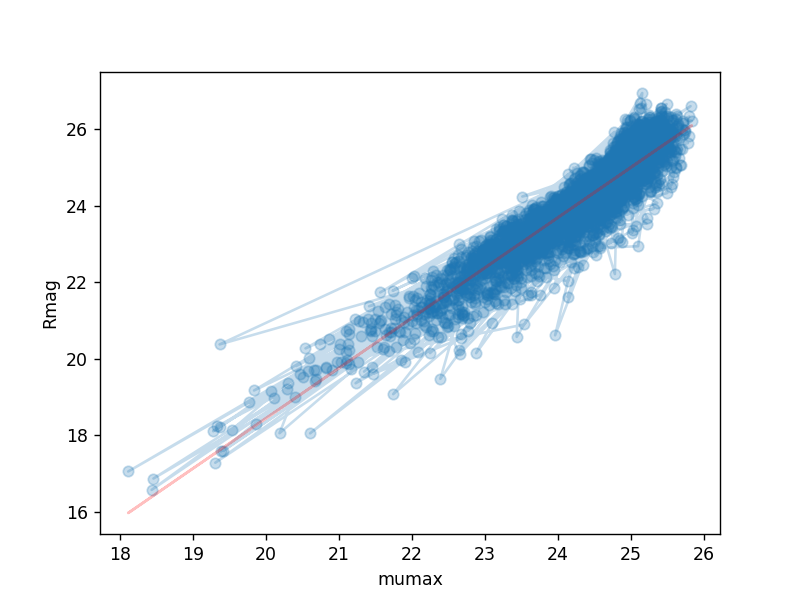

MSE: 0.2682677091066426
R^2: 0.8493705092294048


<IPython.core.display.Javascript object>


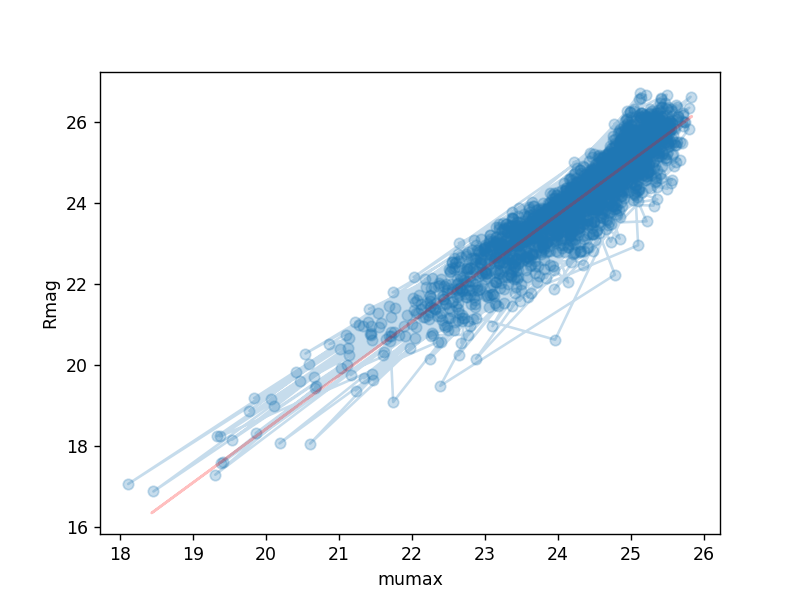

MSE: 0.28207668943503633
R^2: 0.8484048539868627


In [24]:
# split into training, validation, and testing sets.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

#Primera regresión
model = regression(x_train, y_train)
y_hat = model.predict(x_test)

# Mostramos el resultado
plt.figure()
plt.plot(x_train, y_train,'-o', alpha = 0.25)
plt.plot(x_test, y_hat, 'r', alpha = 0.25)
plt.xlabel('mumax')
plt.ylabel('Rmag')


print ("MSE:", metrics.mean_squared_error(y_hat, y_test))
print ("R^2:", metrics.r2_score(y_hat, y_test))
